# COCO dataset

In [1]:
import time
import warnings
from contextlib import contextmanager
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
from einops import rearrange, reduce
from IPython.display import Image, Markdown, display
from osc.data.utils import (
    augment_center_crop,
    img_hwc_to_chw,
    normalize_tf,
    random_resized_crop,
    unnormalize_pt,
)
from osc.models.attentions import CrossAttention, CrossAttentionDecoder, SelfAttention
from osc.models.embeds import LearnedObjectTokens, PositionalEmbedding
from osc.models.vit import ViTBackbone
from osc.utils import cos_pairwise
from sklearn.cluster import KMeans
from torch.nn.functional import binary_cross_entropy_with_logits
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm, trange

device = "cuda:0"
SEED = 0
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
CROP_SIZE = (256, 256)
PATCH_SIZE = 16
EMBED_DIM = 128
BATCH_SIZE = 256
EPOCHS = 40


def topk_precision_recall(preds, target, k=5):
    topk = preds.topk(k, dim=-1)
    topk = torch.gather(target, dim=-1, index=topk.indices)
    topk = topk.sum(dim=-1)
    precision = topk / k
    recall = topk / target.sum(dim=-1)
    torch.nan_to_num_(recall, nan=0.0)
    return precision, recall

## Dataset

2022-03-24 18:30:35.774870: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train samples: 118287
Val samples:   5000
Train images 1st iteration:  ['donut'] ['person', 'tennis racket'] ['person', 'tie'] ['person', 'car', 'bus', 'traffic light', 'fire hydrant', 'umbrella', 'handbag']


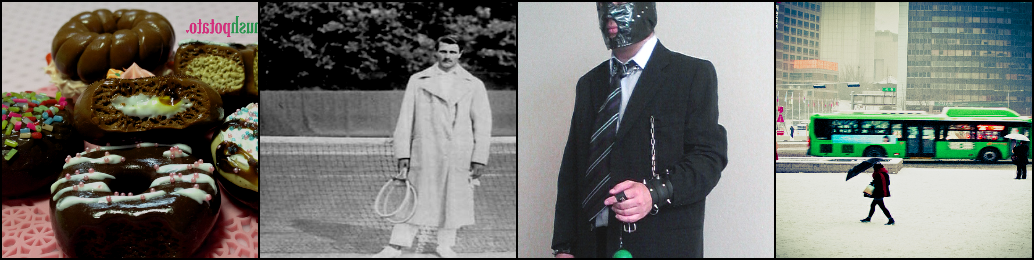

Train images 2nd iteration:  ['cat', 'tv', 'laptop', 'mouse', 'keyboard', 'book'] ['boat'] ['person', 'dog'] ['person', 'skateboard']


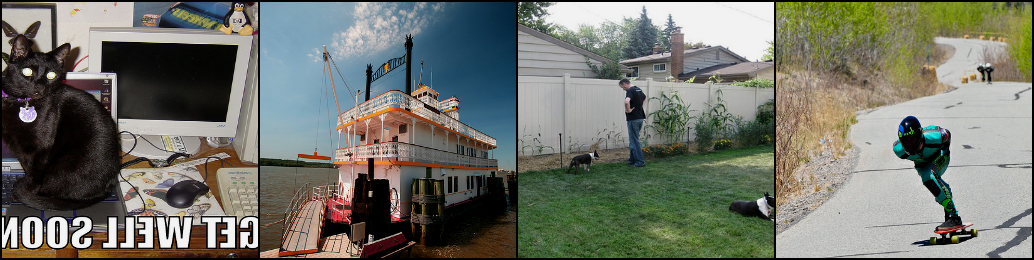

Val images:  ['person', 'bus', 'book'] ['person', 'tennis racket'] ['remote', 'book'] ['person', 'car', 'handbag']


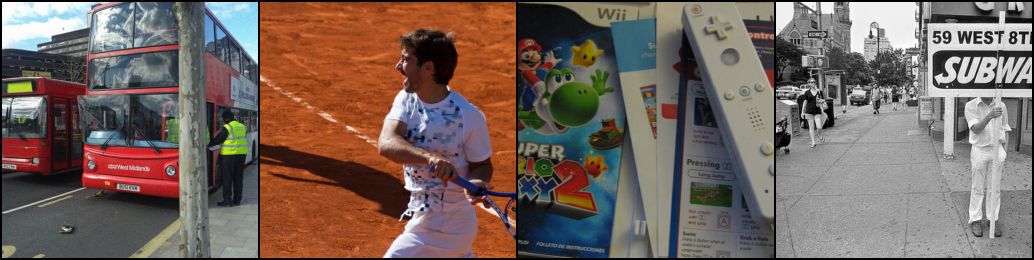

In [2]:
@tf.function
def augment_train(example, seed, *, crop_size, crop_scale, mean, std) -> tf.Tensor:
    img = example["image"]
    img = tf.image.convert_image_dtype(img, tf.float32)

    seeds = tf.random.experimental.stateless_split([seed, 0], num=5)
    img = random_resized_crop(img, size=crop_size, scale=crop_scale, seed=seeds[0])
    img = tf.image.stateless_random_flip_left_right(img, seeds[1])
    img = tf.image.stateless_random_brightness(img, 0.2, seeds[2])
    img = tf.image.stateless_random_saturation(img, 0.9, 1.0, seeds[3])
    img = tf.image.stateless_random_hue(img, 0.05, seeds[4])

    img = normalize_tf(img, mean, std)
    img = img_hwc_to_chw(img)

    target = tf.tensor_scatter_nd_update(
        tf.zeros((80,), dtype=tf.float32),
        indices=example["objects"]["label"][:, None],
        updates=tf.ones_like(example["objects"]["label"], dtype=tf.float32),
    )

    return img, target


@tf.function
def augment_val(example, *, crop_size, mean, std) -> tf.Tensor:
    img = example["image"]
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = augment_center_crop(img, crop_size=crop_size)
    img = normalize_tf(img, mean, std)
    img = img_hwc_to_chw(img)

    target = tf.tensor_scatter_nd_update(
        tf.zeros((80,), dtype=tf.float32),
        indices=example["objects"]["label"][:, None],
        updates=tf.ones_like(example["objects"]["label"], dtype=tf.float32),
    )

    return img, target


def get_datasets():
    ds_train, ds_info = tfds.load(
        "coco/2017",
        split="train",
        shuffle_files=True,
        download=True,
        data_dir="~/coco",
        with_info=True,
        read_config=tfds.ReadConfig(
            shuffle_seed=SEED,
            skip_prefetch=True,
        ),
    )
    ds_train = tf.data.Dataset.zip(
        (
            ds_train.shuffle(1000, seed=SEED, reshuffle_each_iteration=True),
            tf.data.Dataset.random(SEED).shuffle(
                1000, seed=SEED, reshuffle_each_iteration=True
            ),
        )
    )
    ds_train = ds_train.map(
        partial(
            augment_train,
            crop_size=CROP_SIZE,
            crop_scale=(0.5, 1.0),
            mean=IMG_MEAN,
            std=IMG_STD,
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    ds_train = ds_train.batch(
        BATCH_SIZE,
        drop_remainder=True,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_val = tfds.load(
        "coco/2017",
        split="validation",
        shuffle_files=False,
        download=True,
        data_dir="~/coco",
    )
    ds_val = ds_val.map(
        partial(augment_val, crop_size=CROP_SIZE, mean=IMG_MEAN, std=IMG_STD),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    ds_val = ds_val.batch(
        BATCH_SIZE,
        drop_remainder=False,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_val, ds_info


# data pipeline: TF -> numpy -> torch
warnings.filterwarnings(
    "ignore",
    message="The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors",
)

ds_train, ds_val, ds_info = get_datasets()
print("Train samples:", ds_info.splits["train"].num_examples)
print("Val samples:  ", ds_info.splits["validation"].num_examples)

img, target = ds_train.take(1).get_single_element()
print(
    "Train images 1st iteration: ",
    *[
        [
            ds_info.features["objects"]["label"].names[idx]
            for idx in np.nonzero(target[b])[0]
        ]
        for b in range(4)
    ]
)
display(
    ToPILImage()(
        make_grid(unnormalize_pt(torch.from_numpy(img[:4].numpy()), IMG_MEAN, IMG_STD))
    )
)

img, target = ds_train.take(1).get_single_element()
print(
    "Train images 2nd iteration: ",
    *[
        [
            ds_info.features["objects"]["label"].names[idx]
            for idx in np.nonzero(target[b])[0]
        ]
        for b in range(4)
    ]
)
display(
    ToPILImage()(
        make_grid(unnormalize_pt(torch.from_numpy(img[:4].numpy()), IMG_MEAN, IMG_STD))
    )
)

img, target = ds_val.take(1).get_single_element()
print(
    "Val images: ",
    *[
        [
            ds_info.features["objects"]["label"].names[idx]
            for idx in np.nonzero(target[b])[0]
        ]
        for b in range(4)
    ]
)
display(
    ToPILImage()(
        make_grid(unnormalize_pt(torch.from_numpy(img[:4].numpy()), IMG_MEAN, IMG_STD))
    )
)

del ds_train, ds_val

## Model

In [3]:
class MyModel(torch.nn.Module):
    def __init__(
        self,
        img_size=(224, 224),
        patch_size=16,
        embed_dim=128,
        num_classes=10,
        replace_softmax=False,
        replace_layer_norm=False,
    ):
        super().__init__()
        norm_layer = SquashNorm if replace_layer_norm else torch.nn.LayerNorm

        self.backbone = ViTBackbone(
            img_size=img_size,
            patch_size=patch_size,
            pos_embed=PositionalEmbedding(
                np.prod(np.array(img_size) // patch_size), embed_dim=embed_dim
            ),
            embed_dim=embed_dim,
            num_layers=2,
            num_heads=8,
            global_pool="avg",
            norm_layer=norm_layer,
        )
        self.obj_queries = LearnedObjectTokens(embed_dim, num_objects=24)
        self.obj_fn = CrossAttentionDecoder(
            embed_dim, num_layers=2, num_heads=1, norm_layer=norm_layer
        )
        self.cls_fn = torch.nn.Linear(embed_dim, num_classes)

        if replace_softmax:
            for b in self.obj_fn.attn_blocks:
                b.cross_attn.softmax = torch.nn.Sequential(
                    torch.nn.Softmax(dim=-2),
                    L1Norm(dim=-1),
                )

    def forward(self, imgs):
        B = imgs.shape[0]
        _, patch_feats = self.backbone(imgs)
        obj_queries = self.obj_queries().expand(B, -1, -1)
        obj_feats = self.obj_fn(obj_queries, patch_feats)
        obj_feats = obj_feats[:, 1:, :]
        obj_feats = obj_feats.max(dim=-2).values
        logits = self.cls_fn(obj_feats)
        return patch_feats, obj_feats, logits


class L1Norm(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x / x.sum(dim=self.dim, keepdim=True)


class SquashNorm(torch.nn.Module):
    def __init__(self, dim):
        del dim
        super().__init__()

    def forward(self, x):
        norm = torch.linalg.vector_norm(x, dim=-1, keepdim=True)
        return (1 - 1 / norm.exp()) * x / norm


torch.manual_seed(SEED)

model = MyModel(
    img_size=CROP_SIZE,
    num_classes=8,
    replace_layer_norm=False,
    replace_softmax=True,
)

img = torch.rand(3, 3, *CROP_SIZE)
target = (torch.rand(3, 8) > 0.6).float()

with torch.no_grad():
    patch_feats, obj_feats, logits = model(img)

print("patch_feats:", tuple(patch_feats.shape))
print("obj_feats:", tuple(obj_feats.shape))
print("logits:", tuple(logits.shape))

precision, recall = topk_precision_recall(logits, target, k=3)

for b in range(img.shape[0]):
    print()
    print(f"Img {b}")
    print(np.vstack([target[b].numpy(), logits[b].sigmoid().mul(100).numpy().round(2)]))
    print("Top 5:", logits[b].topk(3).indices.numpy())
    print(f"Prec : {precision[b]:.1%}")
    print(f"Rec  : {recall[b]:.1%}")

patch_feats: (3, 256, 128)
obj_feats: (3, 128)
logits: (3, 8)

Img 0
[[ 0.    1.    1.    1.    0.    1.    0.    0.  ]
 [52.43 50.79 49.22 49.03 50.33 47.03 50.72 50.87]]
Top 5: [0 7 1]
Prec : 33.3%
Rec  : 25.0%

Img 1
[[ 1.    0.    0.    1.    0.    0.    0.    0.  ]
 [52.37 50.75 49.34 49.1  50.48 46.95 50.74 50.79]]
Top 5: [0 7 1]
Prec : 33.3%
Rec  : 50.0%

Img 2
[[ 0.    0.    1.    0.    1.    1.    0.    0.  ]
 [52.36 50.74 49.27 49.13 50.36 46.97 50.8  50.91]]
Top 5: [0 7 6]
Prec : 0.0%
Rec  : 0.0%


## Training

Train: 100% 462/462 [02:59<00:00,  2.58it/s]
Valid: 100% 20/20 [00:04<00:00,  4.05it/s]
Train: 100% 462/462 [02:58<00:00,  2.60it/s]
Valid: 100% 20/20 [00:04<00:00,  4.10it/s]
Train: 100% 462/462 [02:58<00:00,  2.60it/s]
Valid: 100% 20/20 [00:05<00:00,  3.85it/s]
Train: 100% 462/462 [02:59<00:00,  2.58it/s]
Valid: 100% 20/20 [00:04<00:00,  4.11it/s]
Train: 100% 462/462 [02:58<00:00,  2.59it/s]
Valid: 100% 20/20 [00:04<00:00,  4.24it/s]
Train: 100% 462/462 [02:58<00:00,  2.59it/s]
Valid: 100% 20/20 [00:04<00:00,  4.11it/s]
Train: 100% 462/462 [02:57<00:00,  2.60it/s]
Valid: 100% 20/20 [00:05<00:00,  3.98it/s]
Train: 100% 462/462 [02:57<00:00,  2.60it/s]
Valid: 100% 20/20 [00:04<00:00,  4.14it/s]
Train: 100% 462/462 [02:58<00:00,  2.59it/s]
Valid: 100% 20/20 [00:04<00:00,  4.09it/s]
Train: 100% 462/462 [02:58<00:00,  2.59it/s]
Valid: 100% 20/20 [00:04<00:00,  4.21it/s]
Train: 100% 462/462 [02:57<00:00,  2.60it/s]
Valid: 100% 20/20 [00:04<00:00,  4.01it/s]
Train: 100% 462/462 [02:54<00:00

Done 40 epochs in 121.9 minutes


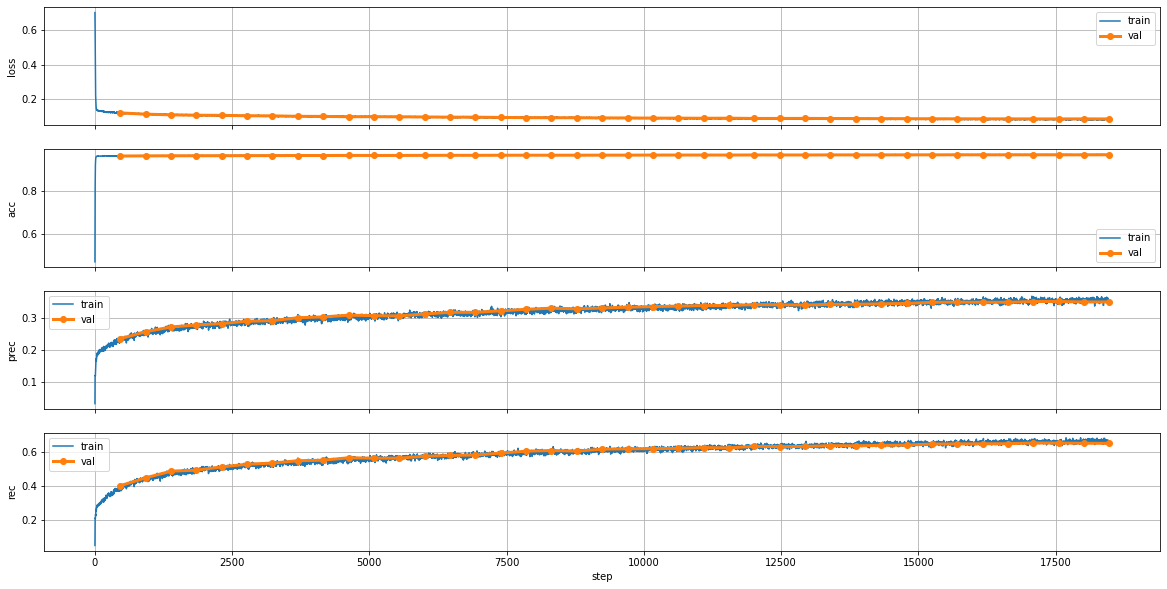

In [4]:
ds_train, ds_val, ds_info = get_datasets()

torch.manual_seed(0)
model = MyModel(
    img_size=CROP_SIZE,
    num_classes=ds_info.features["objects"]["label"].num_classes,
    embed_dim=EMBED_DIM,
    patch_size=PATCH_SIZE,
    replace_layer_norm=False,
    replace_softmax=True,
)

model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

step = 0
h_train = []
h_val = []
start = time.perf_counter()
for epoch in trange(EPOCHS, desc="Epoch", ncols=0, disable=True):

    model.train()
    for img, target in tqdm(
        ds_train.as_numpy_iterator(),
        total=len(ds_train),
        desc="Train",
        ncols=0,
        disable=False,
    ):
        img = torch.from_numpy(img).to(device)
        target = torch.from_numpy(target).to(device)
        *_, logits = model(img)
        loss_train = binary_cross_entropy_with_logits(logits, target)
        acc_train = ((logits.detach() > 0) == target).float().mean()
        pr_train = topk_precision_recall(logits.detach(), target, k=5)
        h_train.append(
            {
                "step": step,
                "loss": loss_train.item(),
                "acc": acc_train.item(),
                "prec": pr_train[0].mean().item(),
                "rec": pr_train[1].mean().item(),
            }
        )
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        step += 1

    with torch.no_grad():
        model.eval()
        count = 0
        loss_val = 0
        acc_val = 0
        prec_val = 0
        rec_val = 0
        for img, target in tqdm(
            ds_val.as_numpy_iterator(),
            total=len(ds_val),
            desc="Valid",
            ncols=0,
            disable=False,
        ):
            img = torch.from_numpy(img).to(device)
            target = torch.from_numpy(target).to(device)
            *_, logits = model(img)
            loss_val += torch.sum(
                torch.mean(
                    binary_cross_entropy_with_logits(logits, target, reduction="none"),
                    dim=-1,
                ),
                dim=-1,
            ).item()
            acc_val += torch.sum(
                torch.mean(((logits.detach() > 0) == target).float(), dim=-1), dim=-1
            ).item()
            pr_val = topk_precision_recall(logits, target, k=5)
            prec_val += pr_val[0].sum().item()
            rec_val += pr_val[1].sum().item()
            count += img.shape[0]
        h_val.append(
            {
                "step": step,
                "loss": loss_val / count,
                "acc": acc_val / count,
                "prec": prec_val / count,
                "rec": rec_val / count,
            }
        )

end = time.perf_counter()
print(f"Done {EPOCHS} epochs in {(end-start)/60:.1f} minutes")
h_train = pd.DataFrame(h_train).set_index("step")
h_val = pd.DataFrame(h_val).set_index("step")

fig, axs = plt.subplots(4, 1, figsize=(20, 10), sharex=True)
for ax, metric in zip(axs, ["loss", "acc", "prec", "rec"]):
    h_train[metric].ewm(alpha=0.2).mean().plot(ax=ax, label="train")
    h_val[metric].plot(ax=ax, marker="o", label="val", lw=3)
    ax.legend()
    ax.grid()
    ax.set_ylabel(metric)

display(fig)
plt.close(fig)

## Inference

Img 0
Ground truth: elephant
Predicted:    elephant 98.7%, bird 9.9%, giraffe 3.9%, bear 3.6%, person 2.8%

Img 1
Ground truth: person, elephant
Predicted:    elephant 98.6%, person 91.2%, bench 17.0%, car 7.9%, handbag 6.5%

Img 2
Ground truth: cat, chair, laptop
Predicted:    laptop 81.0%, keyboard 64.7%, mouse 56.9%, tv 47.2%, book 33.4%

Img 3
Ground truth: tv, laptop, mouse, keyboard, book
Predicted:    tv 75.3%, keyboard 64.6%, mouse 63.4%, laptop 58.1%, book 49.1%



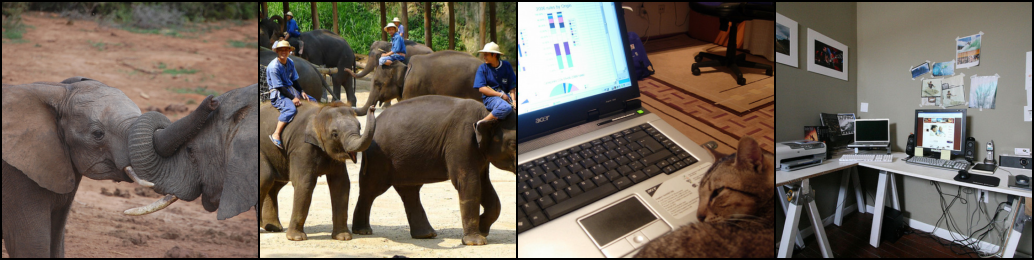

In [5]:
@contextmanager
def forward_with_attns(model):
    module_to_name: Dict[nn.Module, str] = {
        # nn.Module: name
    }
    attns: Dict[str, Tensor] = {
        # name: [batch heads Q K]
    }

    def hook(m, inputs, outputs):
        attns[module_to_name[m]] = outputs.detach()

    handles = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Softmax):
            module_to_name[module] = name
            handle = module.register_forward_hook(hook)
            handles.append(handle)

    try:
        yield attns
    finally:
        for handle in handles:
            handle.remove()


interesting_idxs = [6, 18, 12, 23]
img, target = ds_val.take(1).get_single_element()
img = torch.from_numpy(img.numpy()[interesting_idxs])
target = target.numpy()[interesting_idxs]

with torch.no_grad():
    with forward_with_attns(model) as attns:
        model.eval()
        patch_feats, obj_feats, logits = model(img.to(device))
        topk = logits.sigmoid().topk(5, dim=-1)

for b in range(len(img)):
    print(f"Img {b}")
    print(
        "Ground truth:",
        ", ".join(
            ds_info.features["objects"]["label"].names[idx]
            for idx in np.nonzero(target[b])[0]
        ),
    )
    print(
        "Predicted:   ",
        ", ".join(
            ds_info.features["objects"]["label"].names[idx] + f" {prob.item():.1%}"
            for idx, prob in zip(topk.indices[b], topk.values[b])
        ),
    )
    print()

img = unnormalize_pt(img, IMG_MEAN, IMG_STD)
display(ToPILImage()(make_grid(img)))

## Patch Features

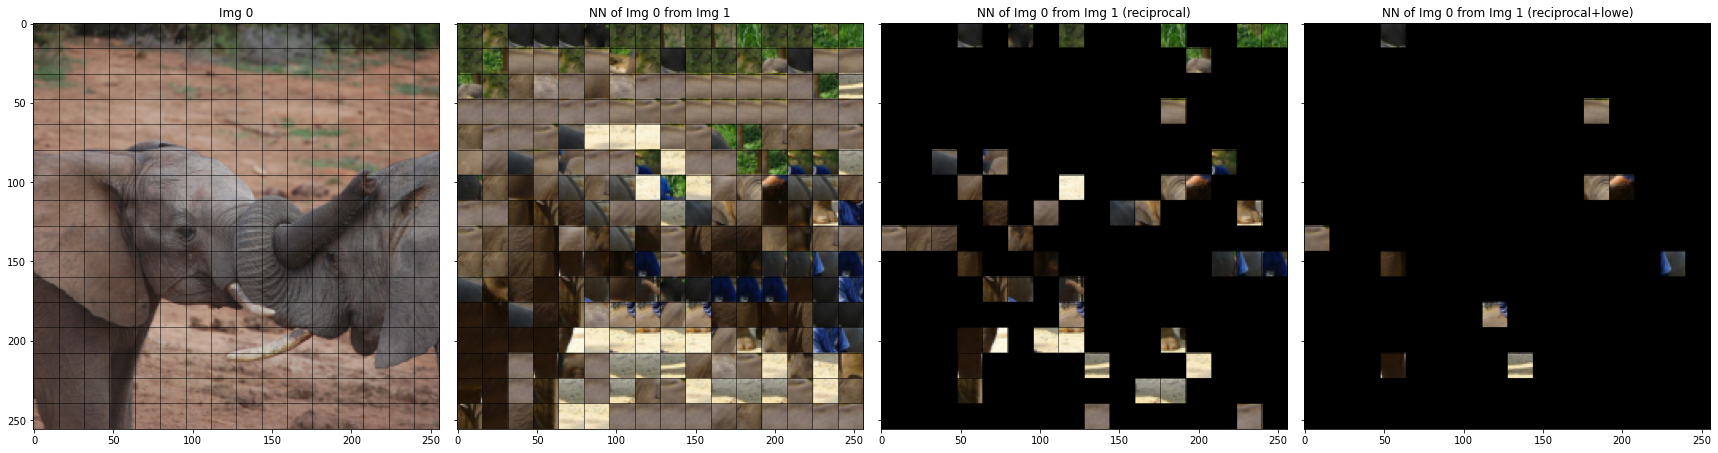

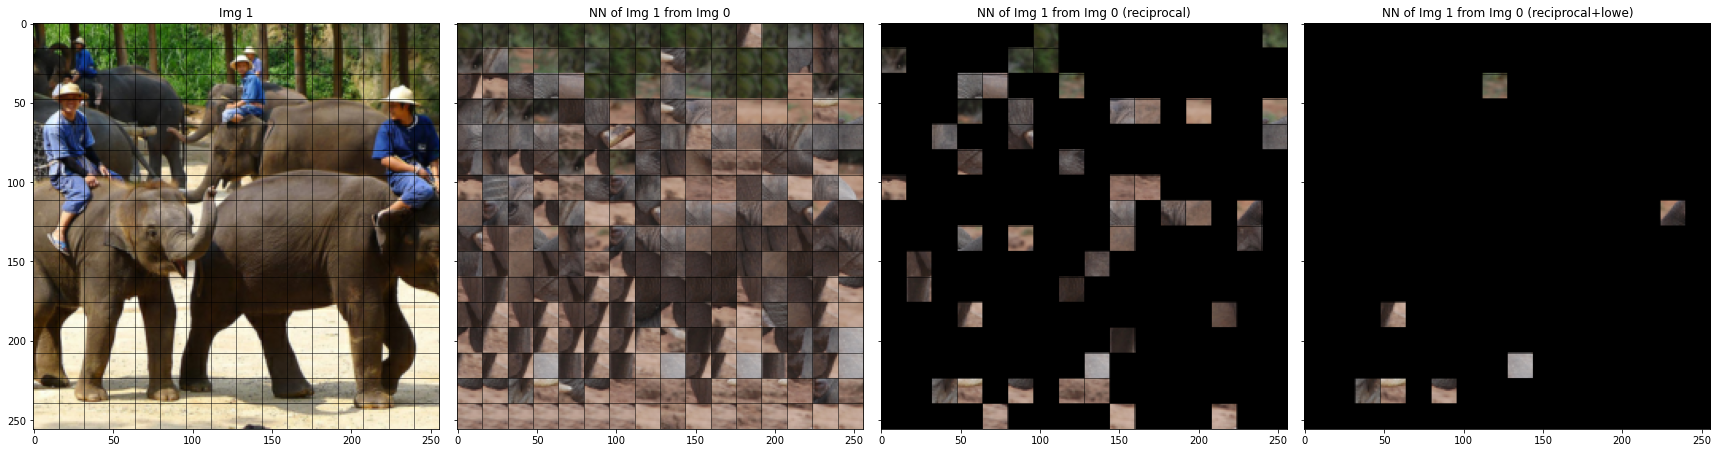

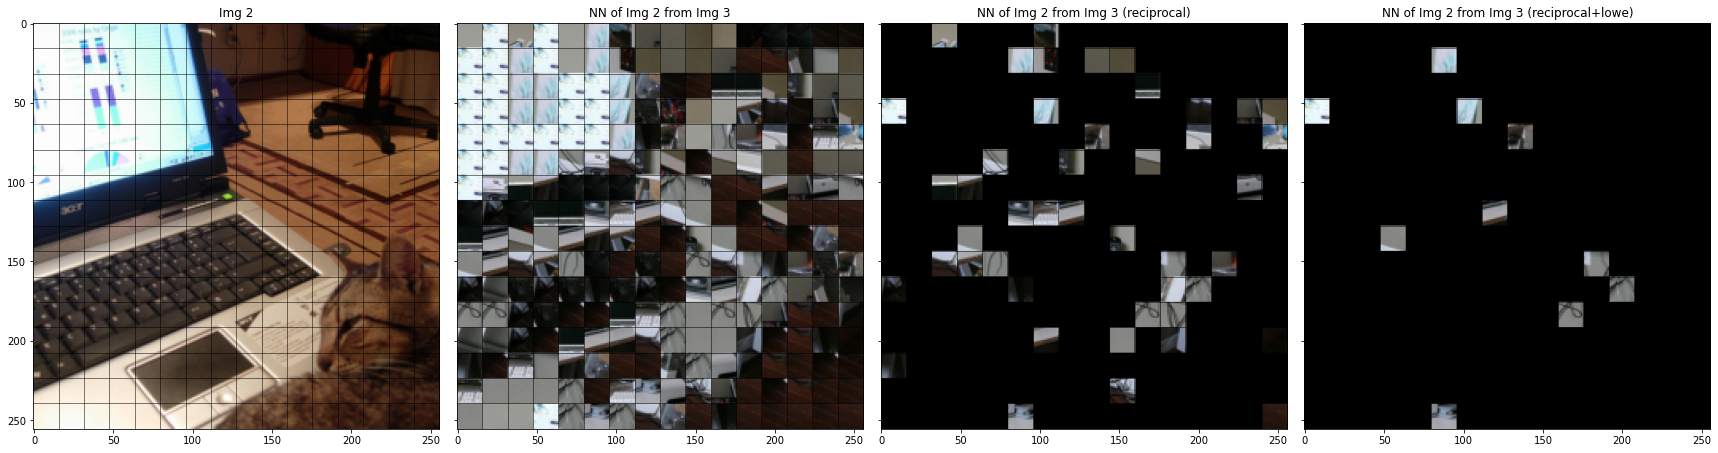

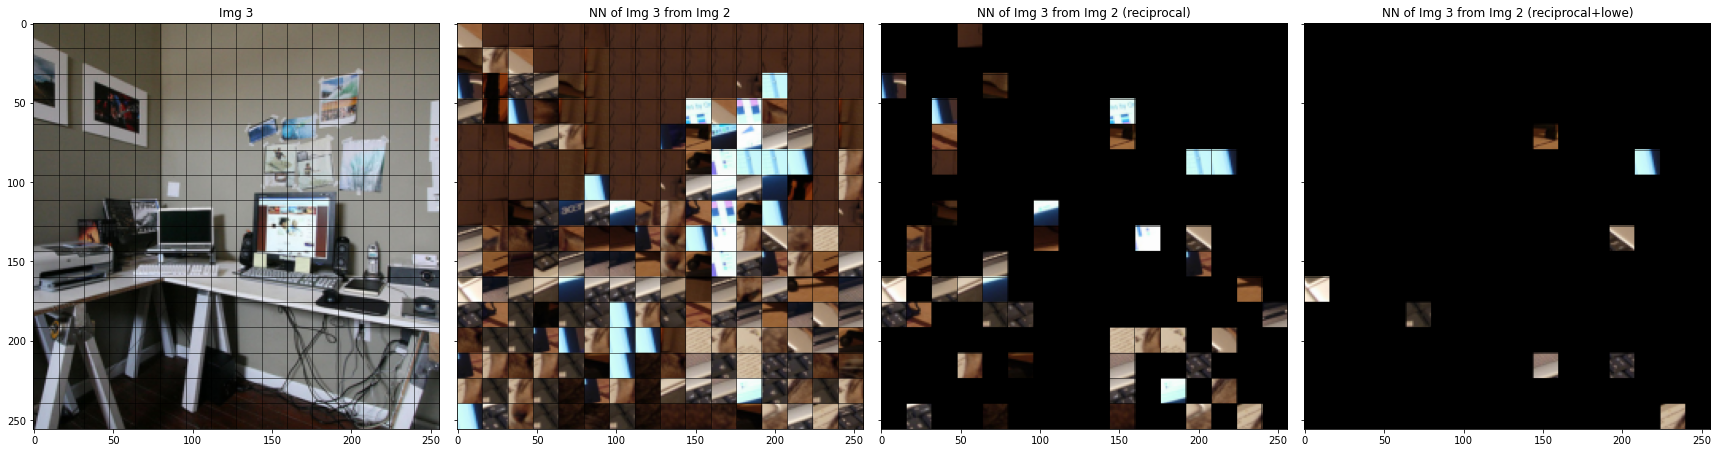

In [6]:
def image_to_patches(img, patch_size=8):
    return rearrange(
        img, "B C (H Ph) (W Pw) -> B H W C Ph Pw", Ph=patch_size, Pw=patch_size
    )


patches = image_to_patches(img, patch_size=PATCH_SIZE)


for b0, b1 in [(0, 1), (1, 0), (2, 3), (3, 2)]:
    fig, axs = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)

    ax = axs[0]
    ax.imshow(ToPILImage()(img[b0]))
    ax.set_title(f"Img {b0}")

    # Reciprocal newarest neighbor + Lowe 1st/2nd ratio test
    cos = cos_pairwise(patch_feats[b0], patch_feats[b1])
    nn_q = torch.topk(cos, k=2, dim=-1)
    lowe12 = nn_q.values[:, 0] / nn_q.values[:, 1]
    lowe12_pass = lowe12 >= 1.1
    nn_q = nn_q.indices[:, 0]
    nn_k = torch.argmax(cos, dim=-2)
    is_reciprocal = nn_k[nn_q] == torch.arange(len(nn_q), device=nn_q.device)
    keep = torch.logical_and(lowe12_pass, is_reciprocal)

    ax = axs[1]
    other = rearrange(patches[b1], "H W C Ph Pw -> (H W) C Ph Pw")
    other = other[nn_q, ...]
    other = rearrange(other, "(H W) C Ph Pw -> C (H Ph) (W Pw)", H=patches[b1].shape[0])
    ax.imshow(ToPILImage()(other))
    ax.set_title(f"NN of Img {b0} from Img {b1}")

    ax = axs[2]
    other = rearrange(patches[b1], "H W C Ph Pw -> (H W) C Ph Pw")
    other = other[nn_q, ...]
    other = other * is_reciprocal.float().cpu()[:, None, None, None]
    other = rearrange(other, "(H W) C Ph Pw -> C (H Ph) (W Pw)", H=patches[b1].shape[0])
    ax.imshow(ToPILImage()(other))
    ax.set_title(f"NN of Img {b0} from Img {b1} (reciprocal)")

    ax = axs[3]
    other = rearrange(patches[b1], "H W C Ph Pw -> (H W) C Ph Pw")
    other = other[nn_q, ...]
    other = other * keep.float().cpu()[:, None, None, None]
    other = rearrange(other, "(H W) C Ph Pw -> C (H Ph) (W Pw)", H=patches[b1].shape[0])
    ax.imshow(ToPILImage()(other))
    ax.set_title(f"NN of Img {b0} from Img {b1} (reciprocal+lowe)")

    for ax in axs:
        for i in range(PATCH_SIZE, img[b0].shape[1], PATCH_SIZE):
            ax.axhline(i - 0.5, lw=0.5, color="black")
        for j in range(PATCH_SIZE, img[b0].shape[2], PATCH_SIZE):
            ax.axvline(j - 0.5, lw=0.5, color="black")

    fig.tight_layout()
    display(fig)
    plt.close(fig)

## Attentions

backbone.attn_blocks.0.attn.softmax           (4, 8, 256, 256)
backbone.attn_blocks.1.attn.softmax           (4, 8, 256, 256)
obj_fn.attn_blocks.0.self_attn.softmax        (4, 1, 24, 24)
obj_fn.attn_blocks.0.cross_attn.softmax.0     (4, 1, 24, 256)
obj_fn.attn_blocks.1.self_attn.softmax        (4, 1, 24, 24)
obj_fn.attn_blocks.1.cross_attn.softmax.0     (4, 1, 24, 256)


### Img 0

Ground truth: elephant

Predicted: elephant 98.7%, bird 9.9%, giraffe 3.9%, bear 3.6%, person 2.8%

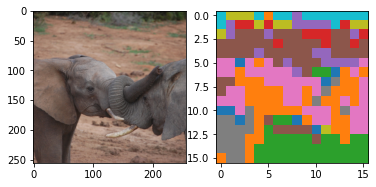

`backbone.attn_blocks.0.attn.softmax`

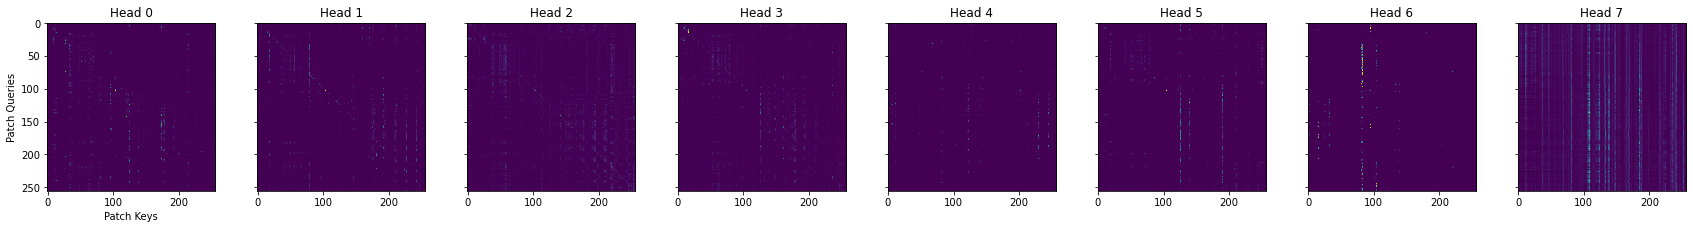

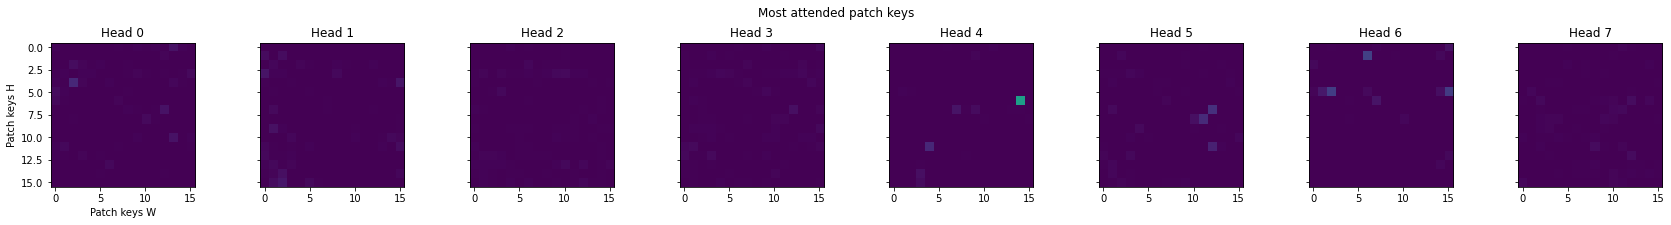

`backbone.attn_blocks.1.attn.softmax`

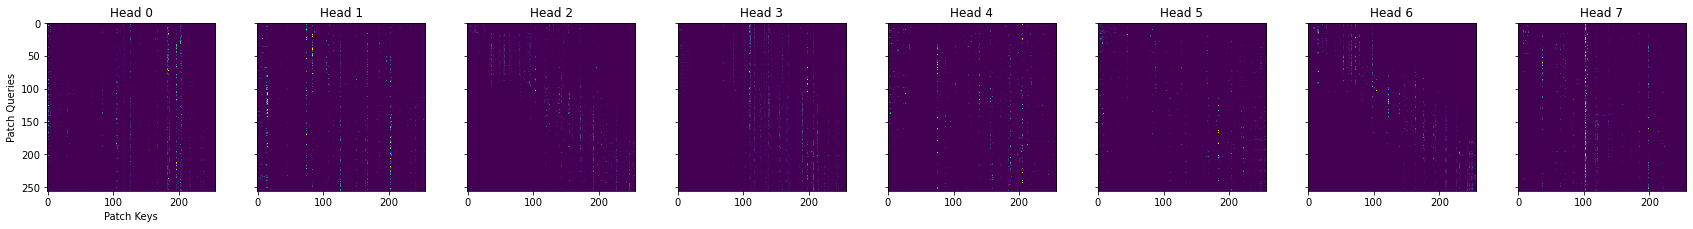

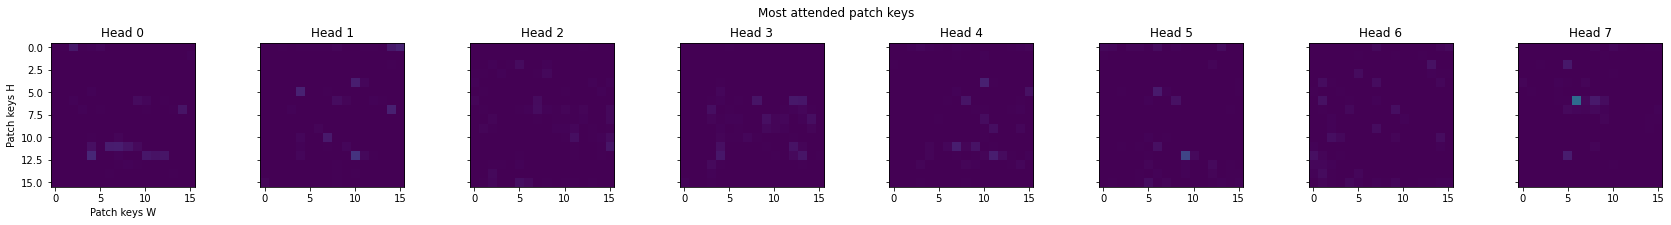

`obj_fn.attn_blocks.0.self_attn.softmax`

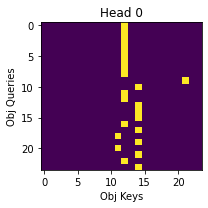

`obj_fn.attn_blocks.0.cross_attn.softmax.0`

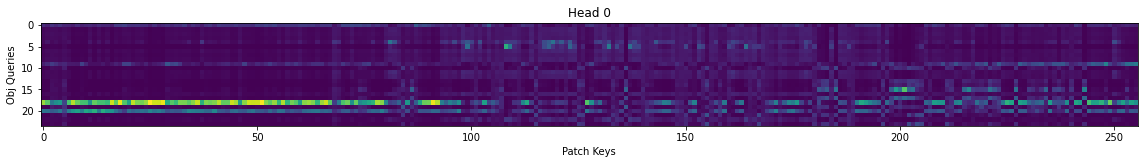

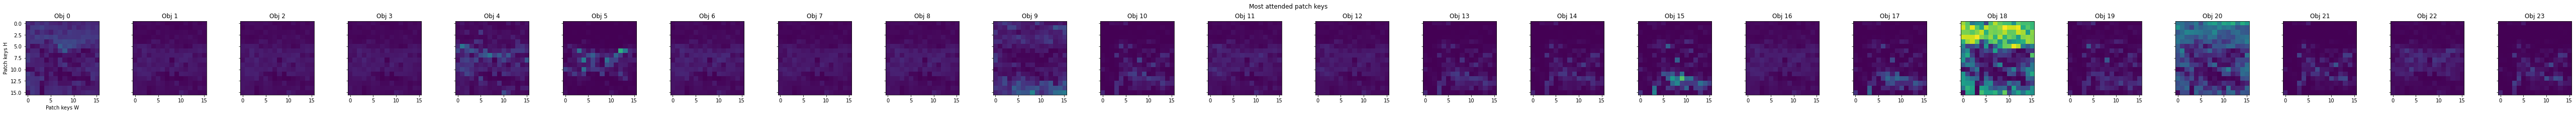

`obj_fn.attn_blocks.1.self_attn.softmax`

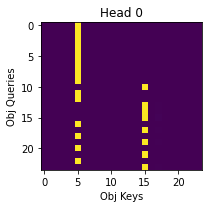

`obj_fn.attn_blocks.1.cross_attn.softmax.0`

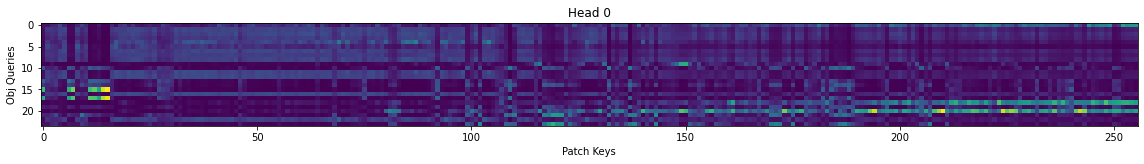

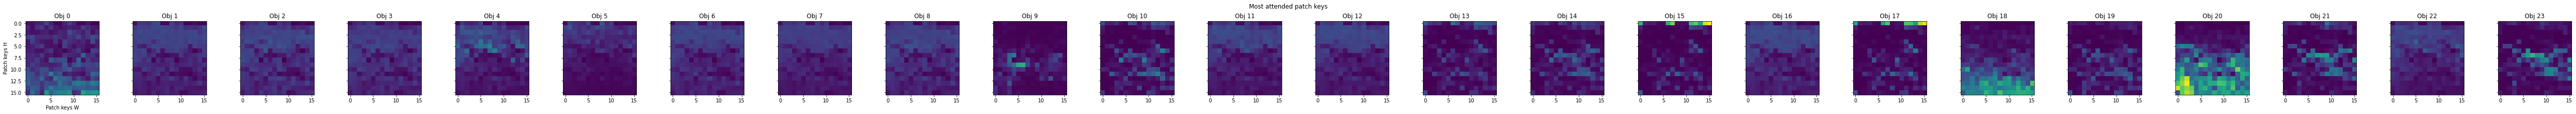

### Img 1

Ground truth: person, elephant

Predicted: elephant 98.6%, person 91.2%, bench 17.0%, car 7.9%, handbag 6.5%

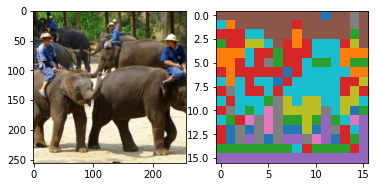

`backbone.attn_blocks.0.attn.softmax`

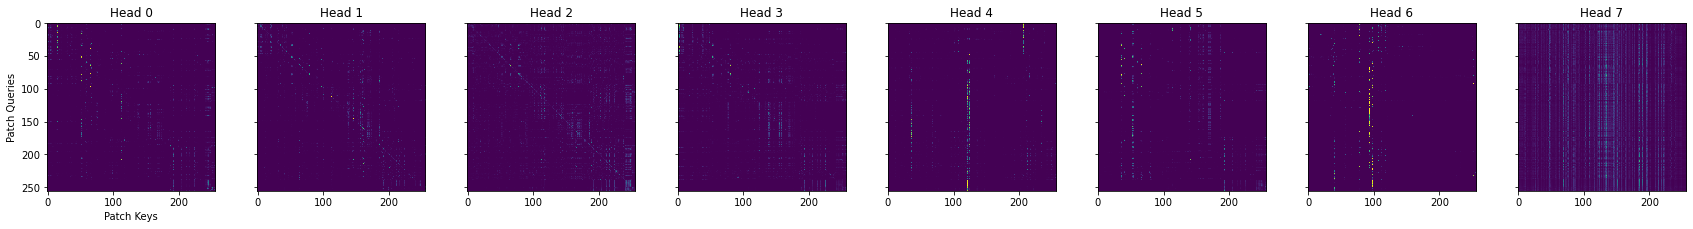

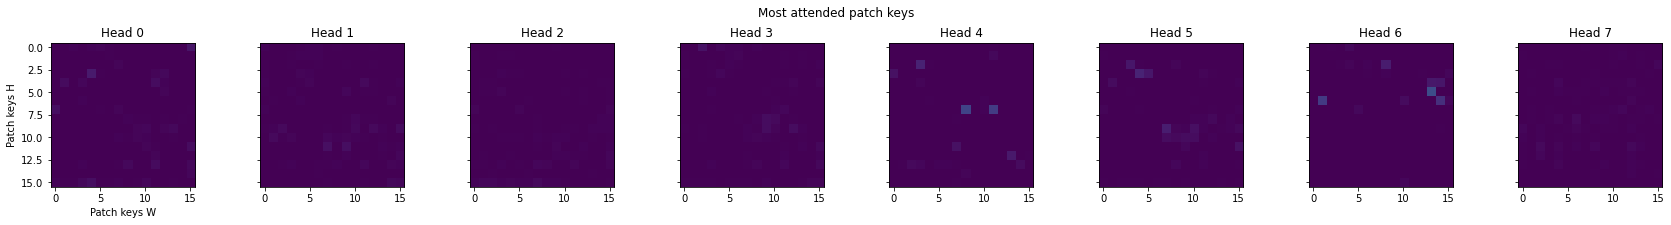

`backbone.attn_blocks.1.attn.softmax`

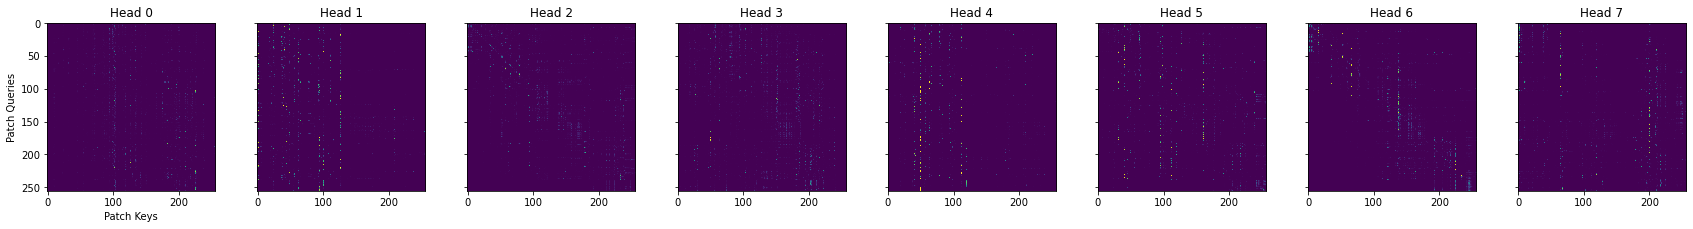

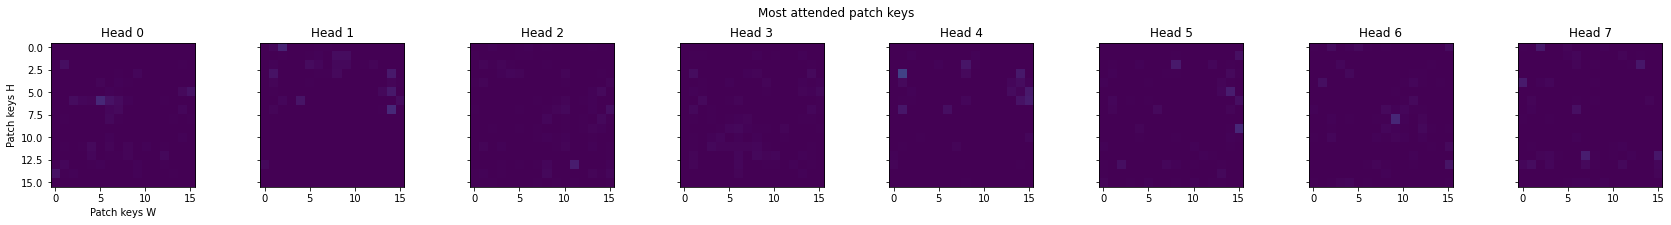

`obj_fn.attn_blocks.0.self_attn.softmax`

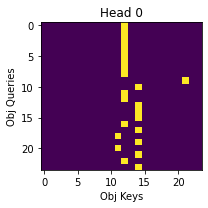

`obj_fn.attn_blocks.0.cross_attn.softmax.0`

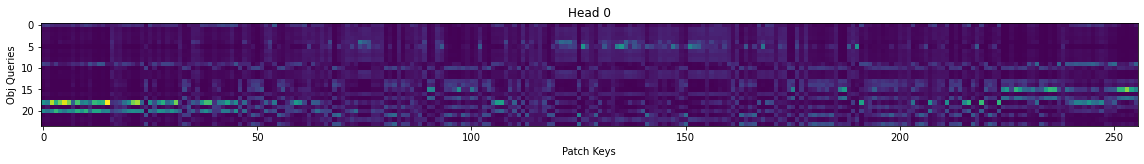

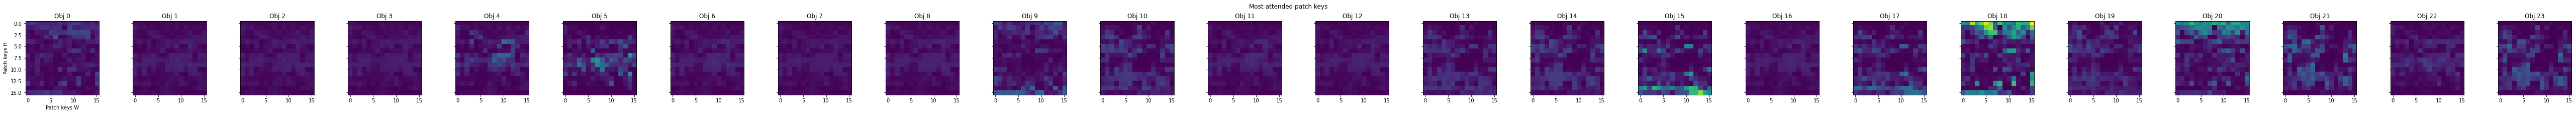

`obj_fn.attn_blocks.1.self_attn.softmax`

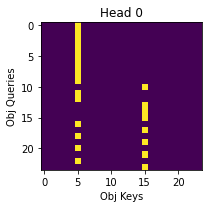

`obj_fn.attn_blocks.1.cross_attn.softmax.0`

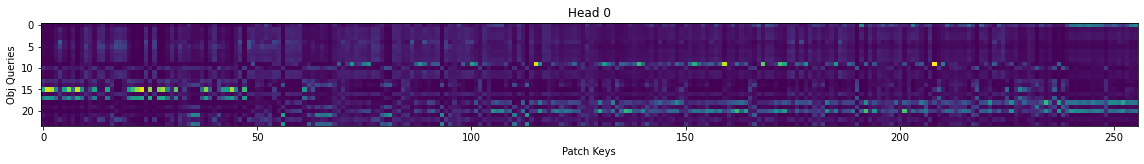

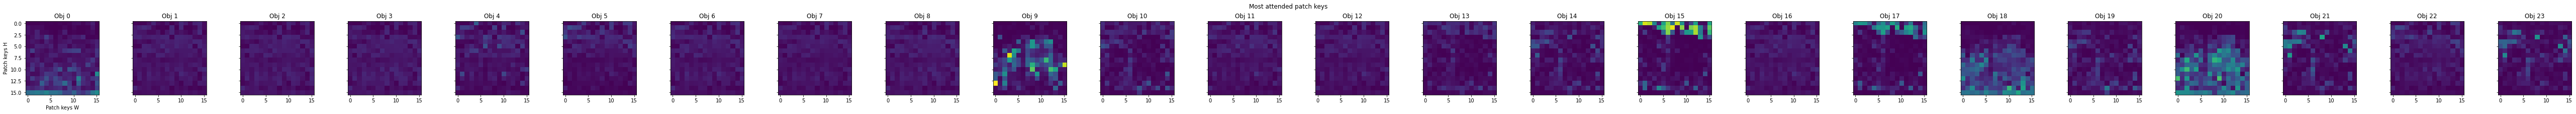

### Img 2

Ground truth: cat, chair, laptop

Predicted: laptop 81.0%, keyboard 64.7%, mouse 56.9%, tv 47.2%, book 33.4%

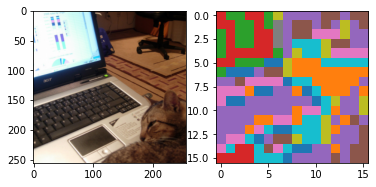

`backbone.attn_blocks.0.attn.softmax`

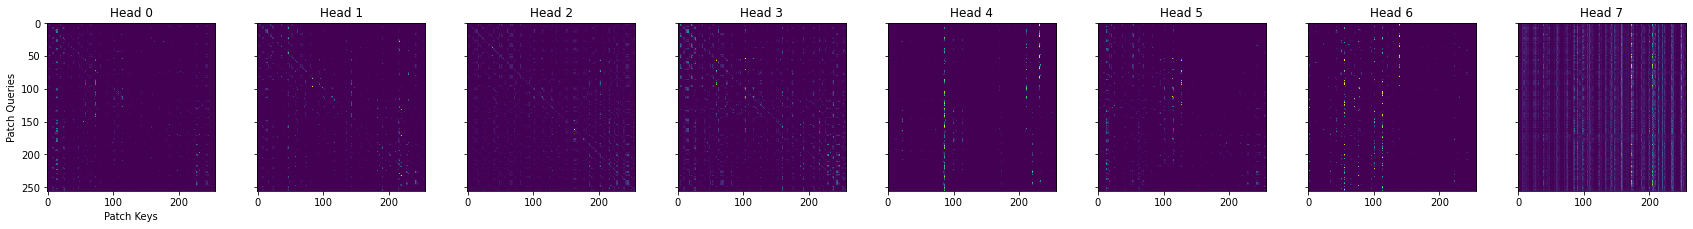

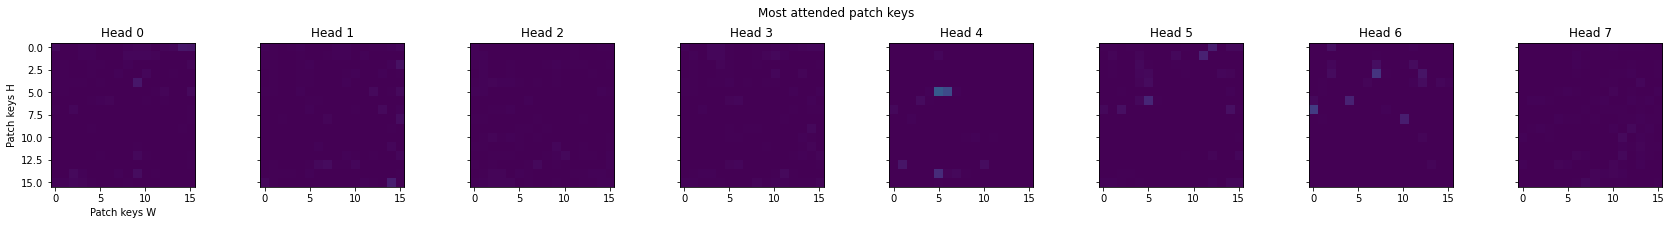

`backbone.attn_blocks.1.attn.softmax`

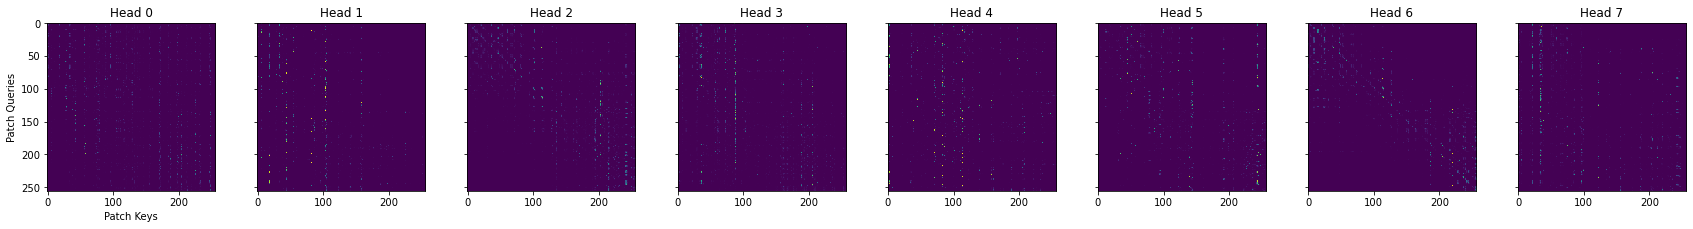

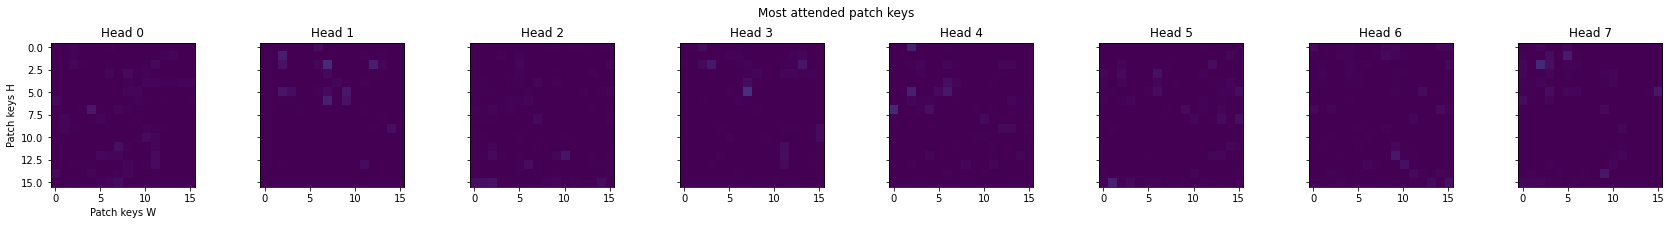

`obj_fn.attn_blocks.0.self_attn.softmax`

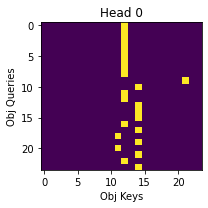

`obj_fn.attn_blocks.0.cross_attn.softmax.0`

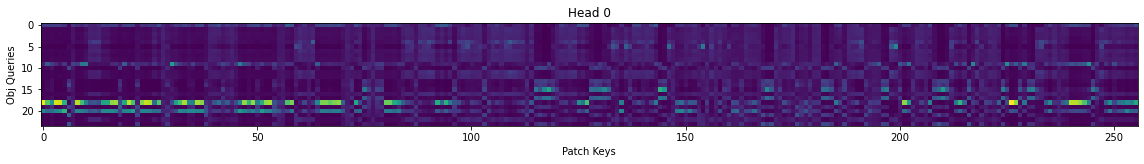

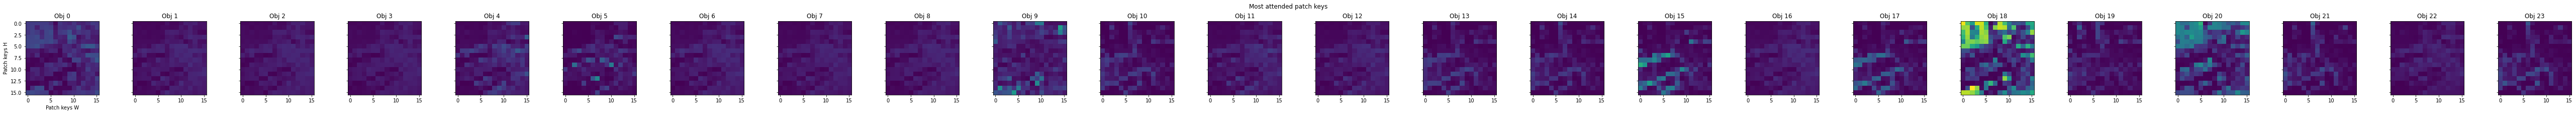

`obj_fn.attn_blocks.1.self_attn.softmax`

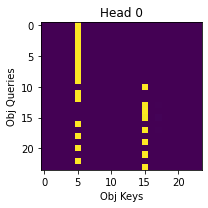

`obj_fn.attn_blocks.1.cross_attn.softmax.0`

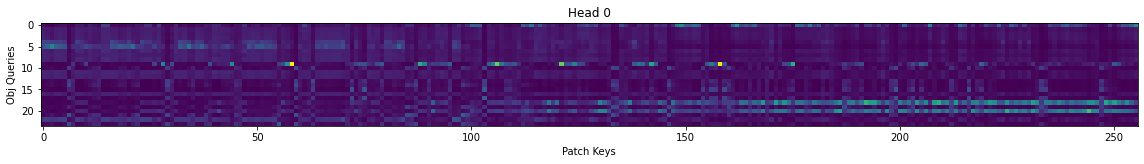

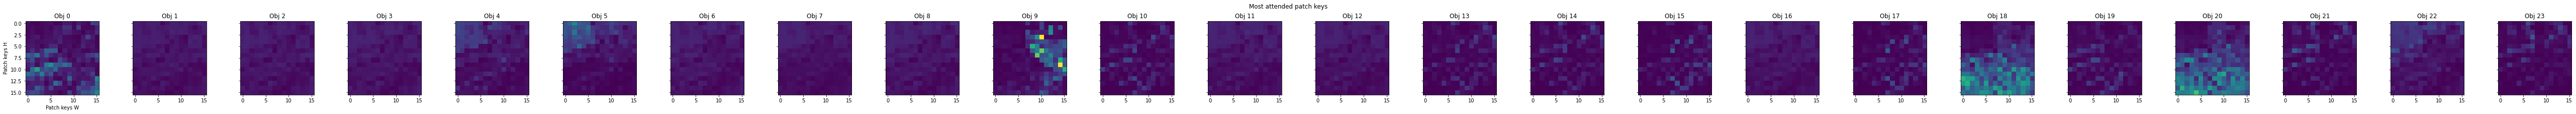

### Img 3

Ground truth: tv, laptop, mouse, keyboard, book

Predicted: tv 75.3%, keyboard 64.6%, mouse 63.4%, laptop 58.1%, book 49.1%

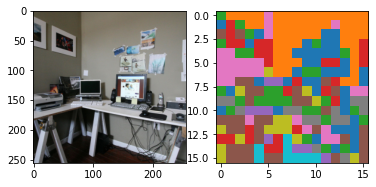

`backbone.attn_blocks.0.attn.softmax`

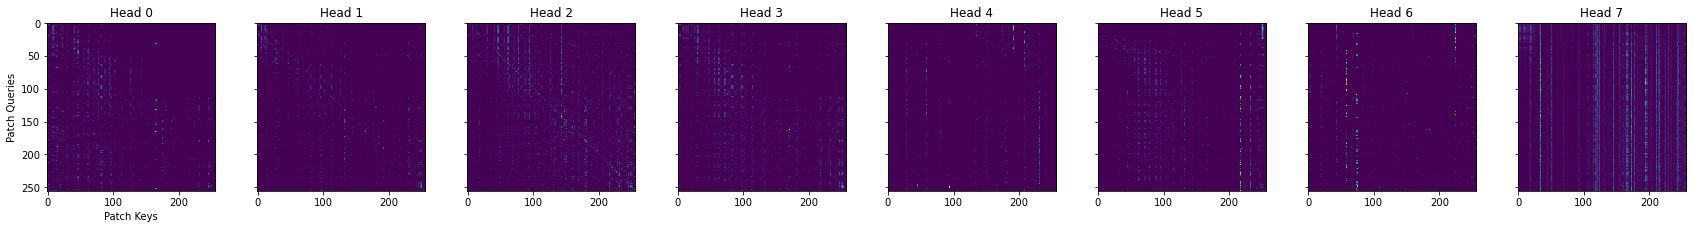

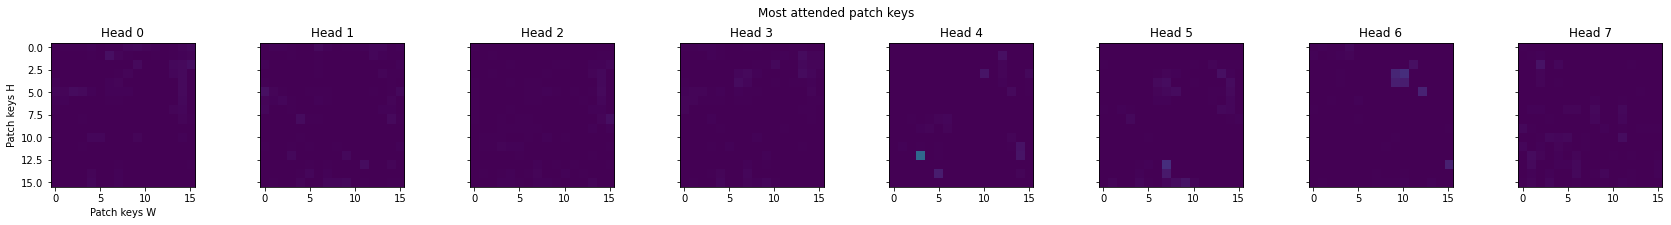

`backbone.attn_blocks.1.attn.softmax`

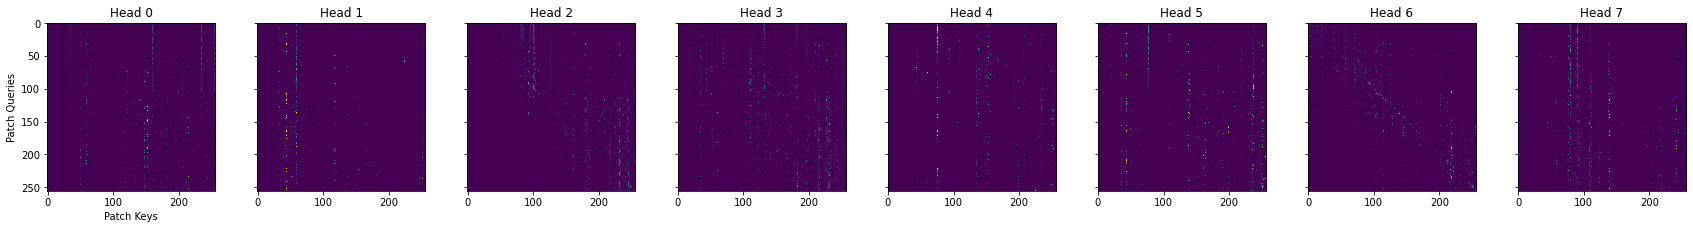

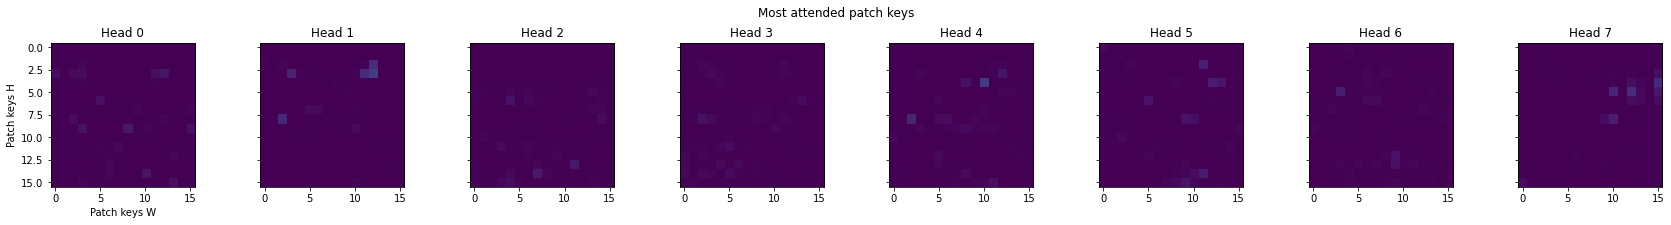

`obj_fn.attn_blocks.0.self_attn.softmax`

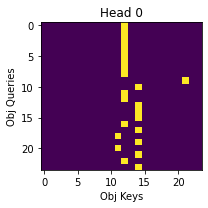

`obj_fn.attn_blocks.0.cross_attn.softmax.0`

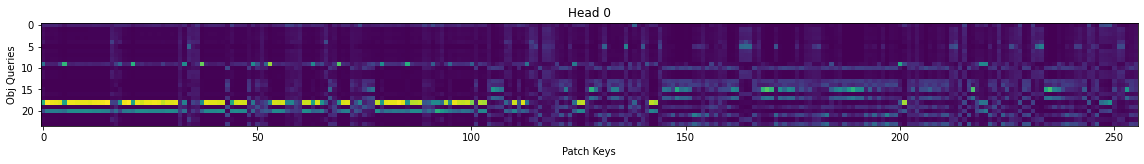

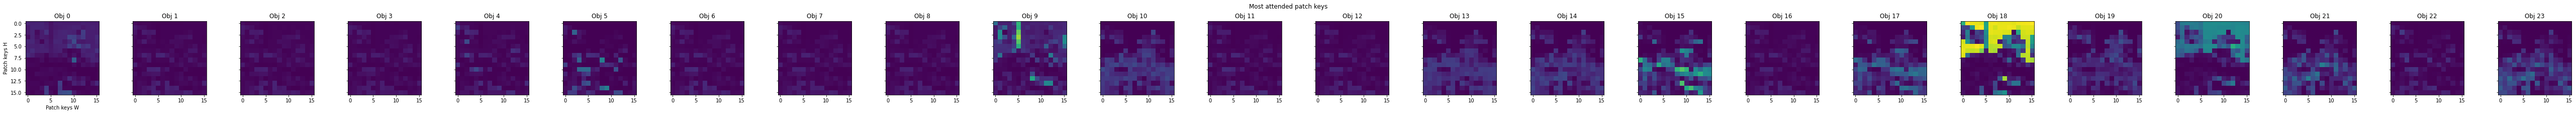

`obj_fn.attn_blocks.1.self_attn.softmax`

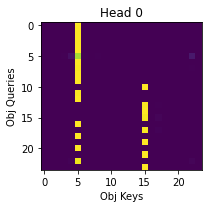

`obj_fn.attn_blocks.1.cross_attn.softmax.0`

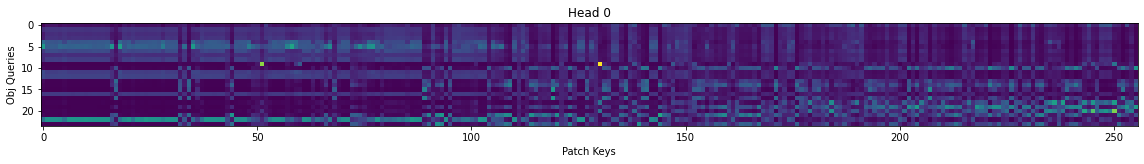

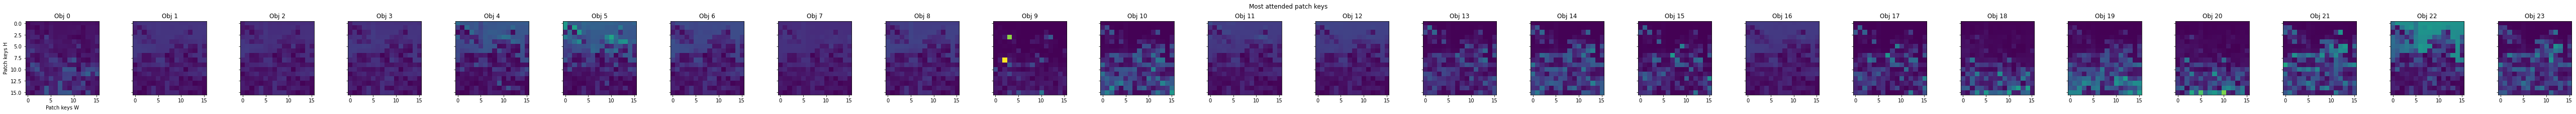

In [7]:
for name, attn in attns.items():
    print(f"{name:<45}", tuple(attn.shape))

for b in range(len(img)):
    display(Markdown(f"### Img {b}"))
    display(
        Markdown(
            "Ground truth: "
            + ", ".join(
                ds_info.features["objects"]["label"].names[idx]
                for idx in np.nonzero(target[b])[0]
            )
        )
    )
    display(
        Markdown(
            "Predicted: "
            + ", ".join(
                ds_info.features["objects"]["label"].names[idx] + f" {prob.item():.1%}"
                for idx, prob in zip(topk.indices[b], topk.values[b])
            )
        )
    )

    kmeans = KMeans(n_clusters=10, random_state=SEED)
    clusters = kmeans.fit_predict(patch_feats[b].detach().cpu())
    clusters = clusters.reshape(
        int(np.sqrt(len(clusters))), int(np.sqrt(len(clusters)))
    )

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(ToPILImage()(img[b]))
    axs[1].imshow(clusters, cmap="tab10")
    display(fig)
    plt.close(fig)

    for layer, attn in attns.items():
        display(Markdown(f"`{layer}`"))
        attn = attn[b].cpu()
        num_heads, Q, K = attn.shape

        if layer.startswith("backbone"):
            fig, axs = plt.subplots(
                1,
                num_heads,
                figsize=(num_heads * 3, 3),
                sharex=True,
                sharey=True,
                squeeze=False,
            )
            axs[0, 0].set_ylabel("Patch Queries")
            axs[0, 0].set_xlabel("Patch Keys")
            for h, ax in enumerate(axs[0]):
                ax.imshow(attn[h], interpolation="none")
                ax.set_title(f"Head {h}")
            fig.tight_layout()
            display(fig)
            plt.close(fig)

            fig, axs = plt.subplots(
                1,
                num_heads,
                figsize=(num_heads * 3, 3),
                sharex=True,
                sharey=True,
                squeeze=False,
            )
            axs[0, 0].set_xlabel("Patch keys W")
            axs[0, 0].set_ylabel("Patch keys H")
            attn = reduce(
                attn,
                "head Q (Kh Kw) -> head Kh Kw",
                Kh=int(np.sqrt(K)),
                Kw=int(np.sqrt(K)),
                reduction="mean",
            )
            for h, ax in enumerate(axs[0]):
                # ax.imshow(attn[h], interpolation="none", vmin=0, vmax=1)
                ax.imshow(attn[h], interpolation="none", vmin=0, vmax=1)
                ax.set_title(f"Head {h}")
            fig.suptitle("Most attended patch keys")
            fig.tight_layout()
            display(fig)
            plt.close(fig)

        if layer.startswith("obj_fn"):
            if "self_attn" in layer:
                fig, axs = plt.subplots(
                    1,
                    num_heads,
                    figsize=(num_heads * 3, 3),
                    sharex=True,
                    sharey=True,
                    squeeze=False,
                )
                axs[0, 0].set_ylabel("Obj Queries")
                axs[0, 0].set_xlabel("Obj Keys")
                for h, ax in enumerate(axs[0]):
                    ax.imshow(attn[h], interpolation="none")
                    ax.set_title(f"Head {h}")
                ax.set_aspect("auto")
                fig.tight_layout()
                display(fig)
                plt.close(fig)

            if "cross_attn" in layer:
                fig, axs = plt.subplots(
                    1,
                    num_heads,
                    figsize=((K / Q / 2) * num_heads * 3, 3),
                    sharex=True,
                    sharey=True,
                    squeeze=False,
                )
                axs[0, 0].set_ylabel("Obj Queries")
                axs[0, 0].set_xlabel("Patch Keys")
                for h, ax in enumerate(axs[0]):
                    ax.imshow(attn[h], interpolation="none")
                    ax.set_title(f"Head {h}")
                fig.tight_layout()
                display(fig)
                plt.close(fig)

                fig, axs = plt.subplots(
                    1, Q, figsize=(Q * 3, 3), sharex=True, sharey=True, squeeze=False
                )
                axs[0, 0].set_xlabel("Patch keys W")
                axs[0, 0].set_ylabel("Patch keys H")
                attn = reduce(
                    attn,
                    "head S (Kh Kw) -> S Kh Kw",
                    Kh=int(np.sqrt(K)),
                    Kw=int(np.sqrt(K)),
                    reduction="mean",
                )
                for s, ax in enumerate(axs[0]):
                    ax.imshow(
                        attn[s], interpolation="none", vmin=attn.min(), vmax=attn.max()
                    )
                    ax.set_title(f"Obj {s}")
                fig.suptitle("Most attended patch keys")
                fig.tight_layout()
                display(fig)
                plt.close(fig)